In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import regex as re
import jieba
import networkx as nx
from itertools import combinations
from tqdm import tqdm
import torch
from torch_geometric.utils import from_networkx
from sklearn.manifold import TSNE
from torch_geometric.nn import Node2Vec

In [6]:
df = pd.read_csv('/content/drive/MyDrive/data mining/2020-01.csv')

community = pd.read_csv('/content/drive/MyDrive/data mining/label.csv')

stopwords = set()
with open('/content/drive/MyDrive/data mining/baidu_stopwords.txt', 'r', encoding='utf-8') as file:
    for line in file:
        stopwords.add(line.strip())

df = df[df['content'].str.contains('女', na=False)][['user_id', 'content']]
df.reset_index(drop=True, inplace=True)
df

,user_id,content
0,74003a81d4afb8ab,按惯例最后一天的总结微博 2019 旅游大年mark一笔 春节➡️埃及 清明➡️武隆 五一➡...
1,a75d4827920520fe,#疫苗挽救生命# 今天，我们又收获了两个重要的好消息：中国国家药品监督管理局批准了厦门万泰沧...
2,9df3be38f28d153d,女人这辈子最幸福的大概是有个好家庭嫁个好老公生个健康宝宝有个好公婆没有负债花钱自由真幸运目前...
3,a53900bd8166b99b,#武汉发现不明原因肺炎#女人不要贪慕虚荣。虚荣是一剂毒药，而且会上瘾。
4,abb53ea80f0c8ce9,2019年底很多行内人提及了结婚率，这方面欧美和日本应该可以例证。如果一样的话也就意味着低结...
...,...,...
306319,3ebaa5eaea8d5207,【心疼！这是#22岁感染科护士的手#[泪]】#周刊君与你共同战疫# 胡佩是湖南省儿童医院感染...
306320,6ca5373140a6adc9,【心疼！这是#22岁感染科护士的手#[泪]】#周刊君与你共同战疫# 胡佩是湖南省儿童医院感染...
306321,f3d121c555f55ff7,#湖北省委书记回应一床难求#我不知道现在的武汉这样的情况还有多少。。。 【一家三口疑似新冠肺...
306322,64767b8053fe3987,#韩红爱心驰援武汉##抗击新型肺炎我们在行动# 0131项目实时进展[加油] 转发理由://...


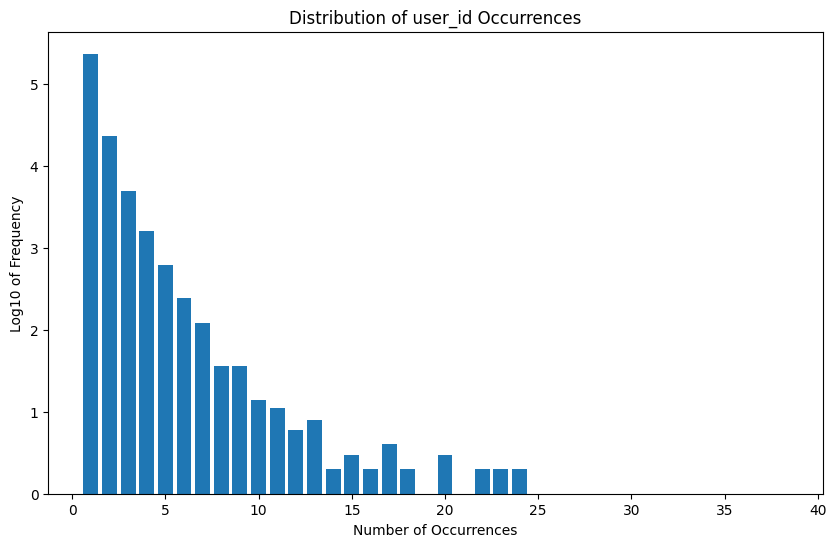

In [7]:
user_id_counts = df['user_id'].value_counts()
distribution = user_id_counts.value_counts().sort_index()
log_distribution = np.log10(distribution.values)
plt.figure(figsize=(10, 6))
plt.bar(distribution.index, log_distribution)
plt.xlabel("Number of Occurrences")
plt.ylabel("Log10 of Frequency")
plt.title("Distribution of user_id Occurrences")
plt.show()

In [8]:
distribution_summary = {
    'Total Unique user_ids': [user_id_counts.count()],
    'Mean': [user_id_counts.mean()],
    'Median': [user_id_counts.median()],
    'Standard Deviation': [user_id_counts.std()],
    'Minimum': [user_id_counts.min()],
    'Maximum': [user_id_counts.max()],
    'Total user_id Occurrences': [user_id_counts.sum()]
}

distribution_summary_df = pd.DataFrame(distribution_summary)
distribution_summary_df

,Total Unique user_ids,Mean,Median,Standard Deviation,Minimum,Maximum,Total user_id Occurrences
0,262739,1.165887,1.0,0.580498,1,38,306324


In [9]:
threshold = 5
df = df[df['user_id'].isin(user_id_counts[user_id_counts >= threshold].index)]
df['tokens'] = df['content'].apply(lambda x: ''.join(re.findall(r'[\u4e00-\u9fa5]', x)))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in jieba.cut(x) if word not in stopwords and len(word) > 1])

<ipython-input-9-b7a2046380b1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = df['content'].apply(lambda x: ''.join(re.findall(r'[\u4e00-\u9fa5]', x)))
Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.896 seconds.
DEBUG:jieba:Loading model cost 0.896 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.
<ipython-input-9-b7a2046380b1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [10]:
def jaccard_similarity(tokens1, tokens2):
    set1 = set(tokens1)
    set2 = set(tokens2)
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union) if len(union) != 0 else 0

In [11]:
gamma_low = 0.4
gamma_high = 1

G = nx.Graph()

for user_id in df['user_id']:
    G.add_node(user_id)

df_grouped = df.groupby('user_id')['tokens'].apply(lambda x: sum(x, [])).reset_index()

to_remove = set()

for (index1, row1), (index2, row2) in tqdm(combinations(df_grouped.iterrows(), 2), desc="Processing pairs"):
    id1, tokens1 = row1['user_id'], row1['tokens']
    id2, tokens2 = row2['user_id'], row2['tokens']
    if id1 in to_remove or id2 in to_remove:
        continue
    similarity = jaccard_similarity(tokens1, tokens2)
    if similarity >= gamma_high:
        to_remove.add(id2)
        continue
    if similarity >= gamma_low:
        G.add_edge(id1, id2)

Processing pairs: 617716it [01:21, 7562.03it/s]


In [12]:
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)
largest_component = max(nx.connected_components(G), key=len)
G_largest = G.subgraph(largest_component).copy()

In [13]:
for node in G_largest.nodes:
    label = community.loc[community['node'] == node, 'label'].values[0]
    G_largest.nodes[node]['label'] = label

In [14]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(
        train_z=z[data.train_mask],
        train_y=data.y[data.train_mask],
        test_z=z[data.test_mask],
        test_y=data.y[data.test_mask],
        max_iter=150,
    )
    return acc


@torch.no_grad()
def plot_points(colors, save=False):
    model.eval()
    z = model().cpu().numpy()
    z = TSNE(n_components=2).fit_transform(z)
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(6):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')

    if save:
        plt.savefig('node2vec.png')
    else:
        plt.show()

In [15]:
data = from_networkx(G_largest)
data.y = torch.tensor([G_largest.nodes[node]['label'] for node in G_largest.nodes])
num_nodes = data.num_nodes

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_size = int(0.8 * num_nodes)
train_indices = torch.randperm(num_nodes)[:train_size]
test_indices = torch.randperm(num_nodes)[train_size:]

data.train_mask[train_indices] = True
data.test_mask[test_indices] = True

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Node2Vec(
    data.edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1.0,
    q=1.0,
    sparse=True,
).to(device)

loader = model.loader(batch_size=128, shuffle=True)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

for epoch in range(1, 101):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

Epoch: 001, Loss: 9.6194, Acc: 0.6923
Epoch: 002, Loss: 8.9157, Acc: 0.7179
Epoch: 003, Loss: 8.3129, Acc: 0.7436
Epoch: 004, Loss: 7.7343, Acc: 0.7436
Epoch: 005, Loss: 7.3232, Acc: 0.7436
Epoch: 006, Loss: 6.8945, Acc: 0.7436
Epoch: 007, Loss: 6.5472, Acc: 0.7436
Epoch: 008, Loss: 6.1599, Acc: 0.7436
Epoch: 009, Loss: 5.9457, Acc: 0.7436
Epoch: 010, Loss: 5.6608, Acc: 0.7436
Epoch: 011, Loss: 5.3685, Acc: 0.7692
Epoch: 012, Loss: 5.1480, Acc: 0.7949
Epoch: 013, Loss: 4.9923, Acc: 0.7949
Epoch: 014, Loss: 4.8515, Acc: 0.7949
Epoch: 015, Loss: 4.6845, Acc: 0.7949
Epoch: 016, Loss: 4.4867, Acc: 0.7949
Epoch: 017, Loss: 4.3710, Acc: 0.8205
Epoch: 018, Loss: 4.3190, Acc: 0.8205
Epoch: 019, Loss: 4.1669, Acc: 0.8462
Epoch: 020, Loss: 4.0777, Acc: 0.8718
Epoch: 021, Loss: 4.0152, Acc: 0.8718
Epoch: 022, Loss: 3.8551, Acc: 0.8718
Epoch: 023, Loss: 3.8113, Acc: 0.8718
Epoch: 024, Loss: 3.7761, Acc: 0.8718
Epoch: 025, Loss: 3.6315, Acc: 0.8718
Epoch: 026, Loss: 3.5817, Acc: 0.8718
Epoch: 027, 

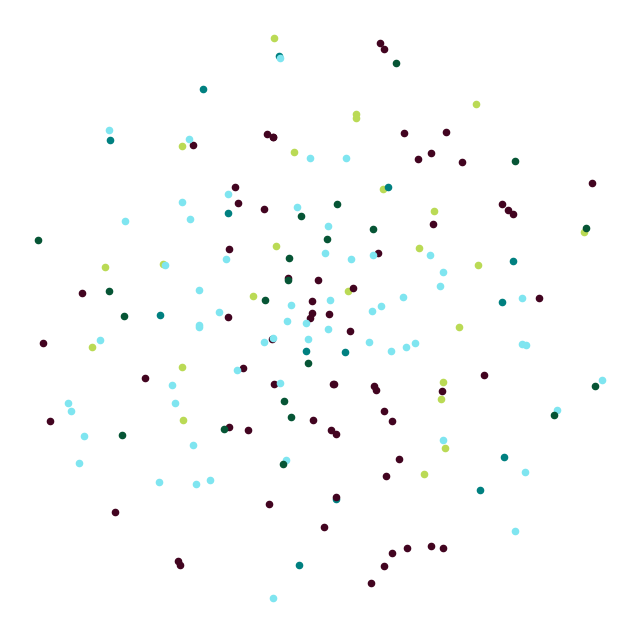

In [17]:
colors = ['#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700']
plot_points(colors)